In [1]:
import matplotlib.pyplot as plt
import numpy as np

import optical_gating_analysis as OG
from tqdm import tqdm

from scipy.stats import gaussian_kde

In [2]:
import matplotlib

matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (9, 9)

# Poincaré Density Plot for 120fps Bloodless Data

## Run optical gating

In [3]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif")
oog.sequence_manager.set_reference_sequence(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif")
oog.sequence_manager.reference_period = 73.106274
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif


Getting phases: 100%|██████████| 37970/37970 [00:00<00:00, 170535.95it/s]


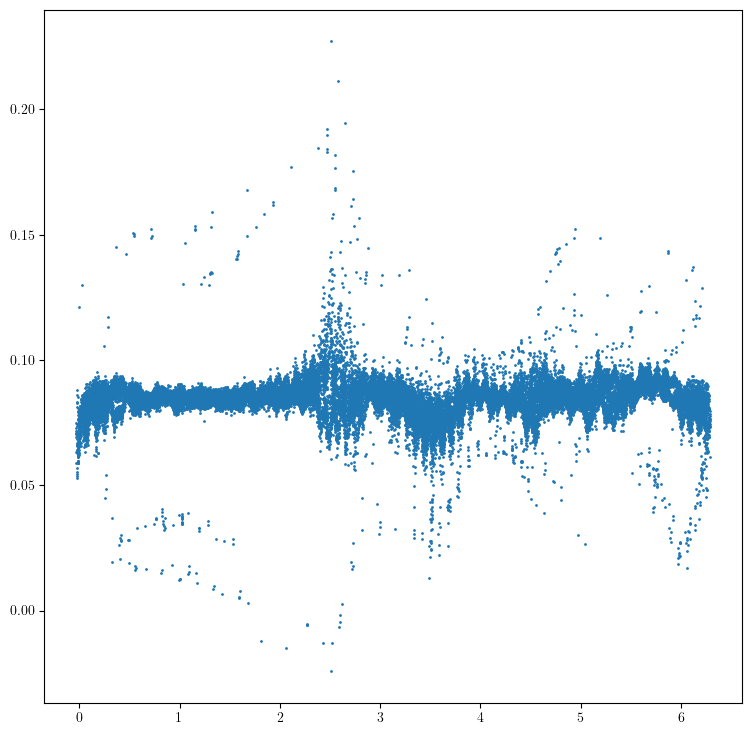

In [29]:
plt.scatter(oog.phases[1::], oog.delta_phases, s = 1)

## Get Density Plot

In [5]:
x = oog.delta_phases[0:-1]
y = oog.delta_phases[1::]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([x, y])

kernel = gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)

## Plot

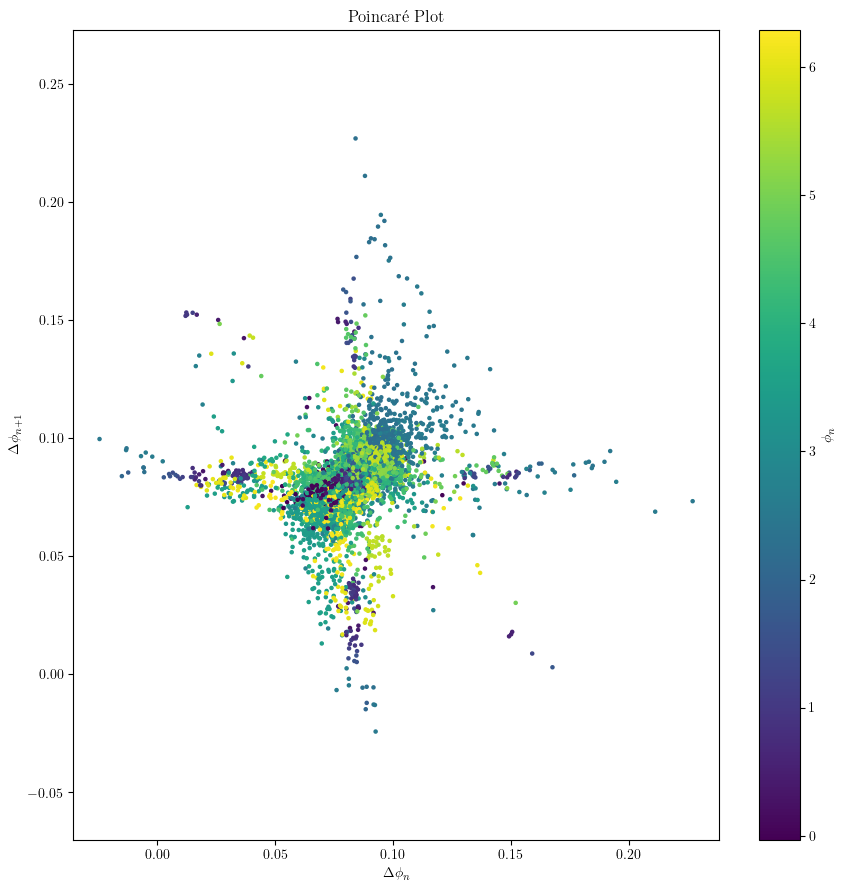

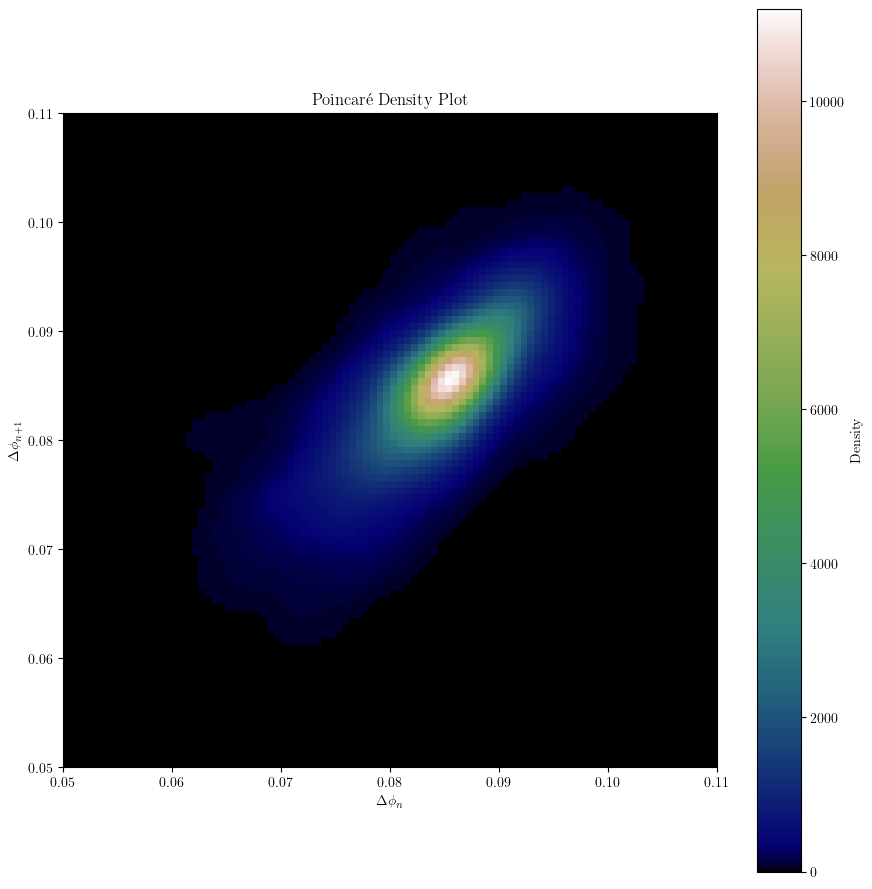

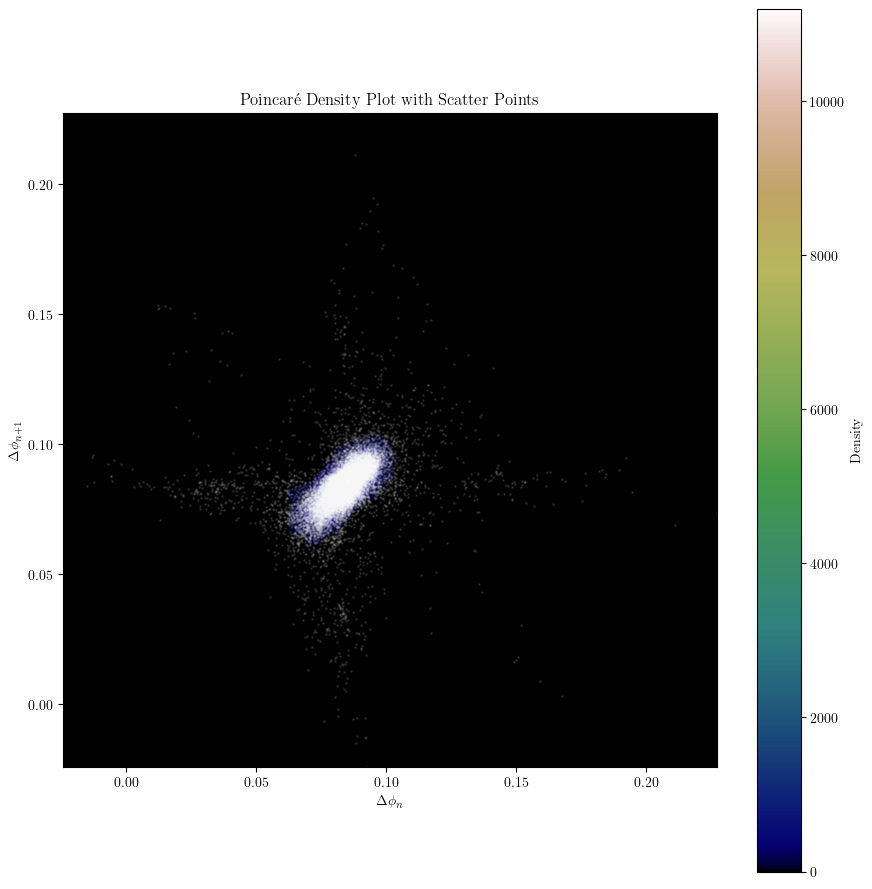

In [6]:
plt.figure(figsize = (9,9))
plt.title("Poincaré Plot")
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], s = 5, c = oog.phases[1:-1])
plt.axis("equal")
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.colorbar(label = "$\phi_n$")
plt.axis("equal")
plt.tight_layout()
plt.show()

plt.figure(figsize = (9,9))
plt.title("Poincaré Density Plot")
plt.imshow(Z, origin = "lower", cmap = "gist_earth", extent = [xmin, xmax, ymin, ymax], interpolation = "none")
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.colorbar(label = "Density")
plt.xlim(0.05, 0.11)
plt.ylim(0.05, 0.11)
plt.tight_layout()
plt.show()

plt.figure(figsize = (9,9))
plt.title("Poincaré Density Plot with Scatter Points")
plt.imshow(Z, origin = "lower", cmap = "gist_earth", extent = [xmin, xmax, ymin, ymax], interpolation = "none")
plt.colorbar(label = "Density")
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], s = 1, c = "white", alpha = 0.1)
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.tight_layout()
plt.show()

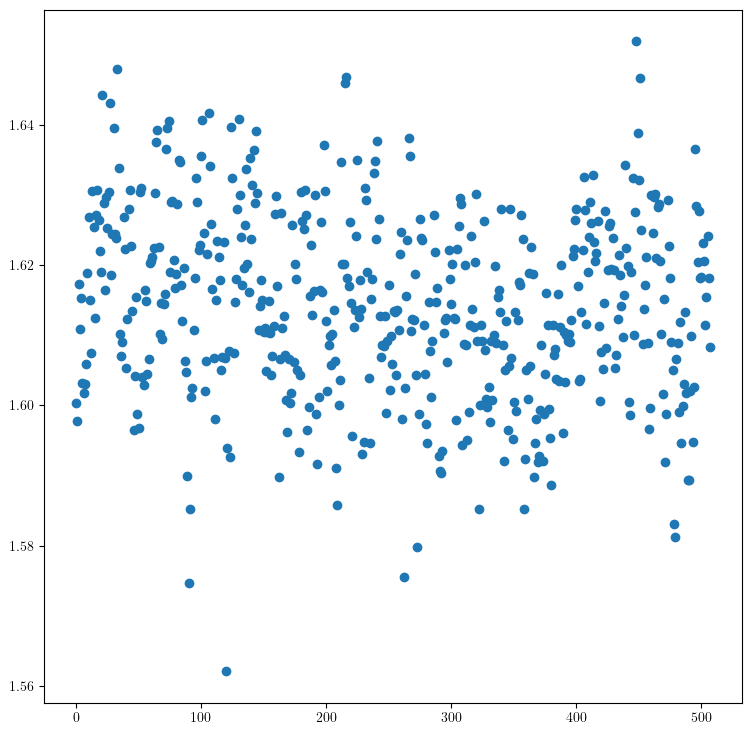

In [28]:
plt.scatter(range(len(gradients)), gradients)

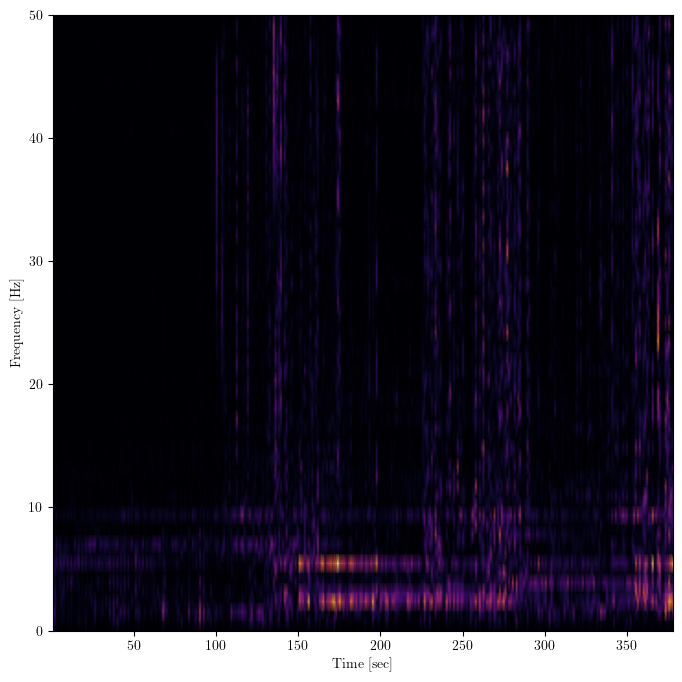

In [25]:
from scipy import signal
f, t, Sxx = signal.spectrogram(oog.delta_phases, fs = 10e1, nperseg = 128, scaling = "spectrum")
plt.figure(figsize = (8,8))
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap = "inferno")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

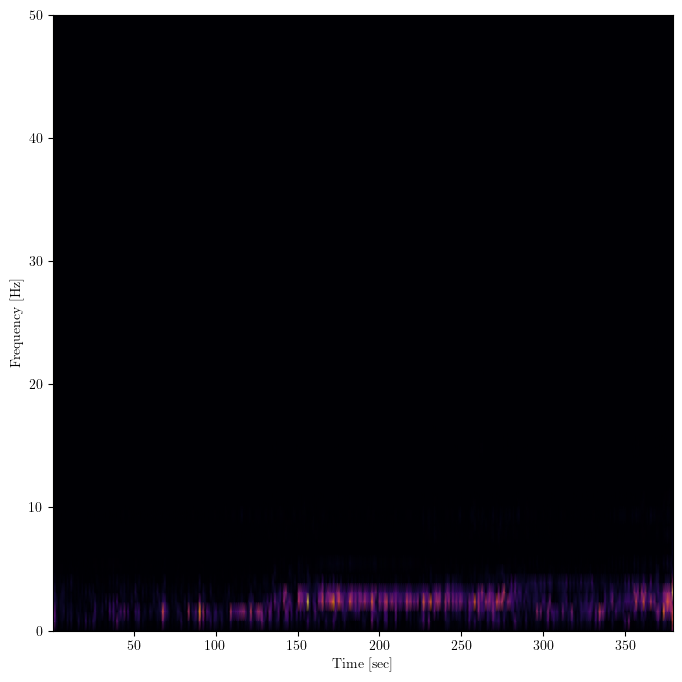

In [23]:
from scipy import signal
f, t, Sxx = signal.spectrogram(np.convolve(oog.delta_phases, np.ones(16)/16), fs = 10e1, nperseg = 128, scaling = "spectrum")
plt.figure(figsize = (8,8))
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap = "inferno")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

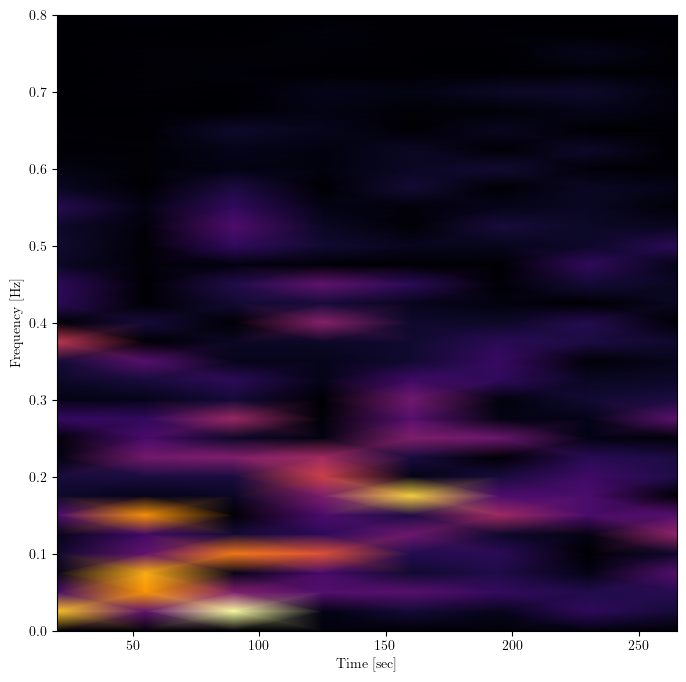

In [45]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = oog.unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.array(OG.radsperframe_to_bps(np.array(gradients),120))

from scipy import signal
f, t, Sxx = signal.spectrogram(1/gradients, fs = 1.6, nperseg = 64, scaling = "spectrum")
plt.figure(figsize = (8,8))
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap = "inferno")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Brownian Motion

## Data Generation

In [7]:
# Parameters
N = 10000
k = 0.3  # Restoring force constant
d = 1  # Damping constant
b = 0.1  # Noise intensity
dt = 1

# Initialise
x_exp = 3
x = x_exp
v = 0
a = 0

# Initialise arrays
x_data = np.zeros(N)
v_data = np.zeros(N)
t_data = np.zeros(N)

# Loop
for i in tqdm(range(N)):
    x_exp += 0.0001
    # Restoring and damping force
    a = (-k*(x - x_exp))
    a -= d*v*dt

    # Apply velocity change
    v += a*dt + b*np.random.normal()*dt

    # Apply position change
    x += v*dt

    # Add to arrays
    x_data[i] = x
    v_data[i] = v
    t_data[i] = i*dt

x_data = np.asarray(x_data)

100%|██████████| 10000/10000 [00:00<00:00, 581903.74it/s]


## Plot Data

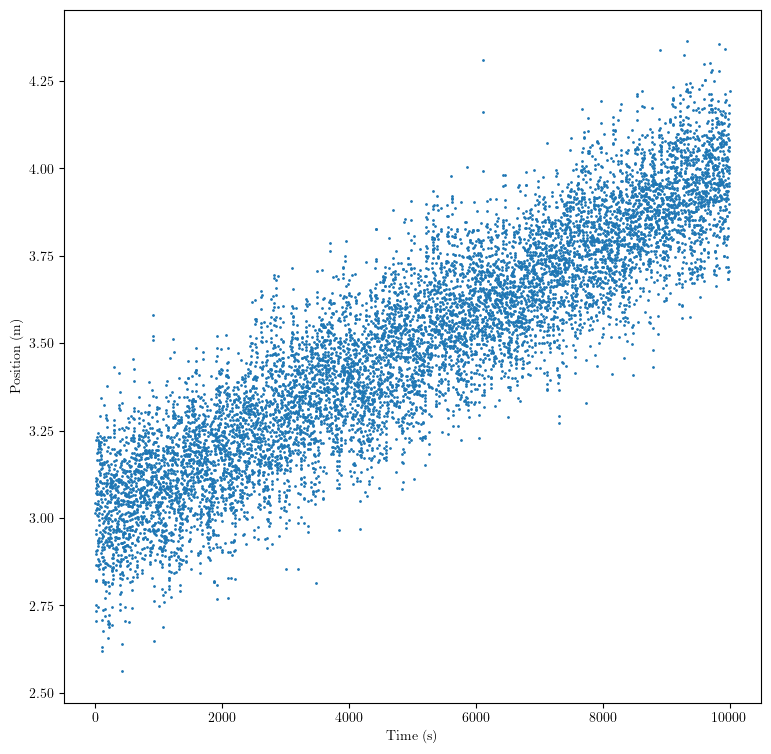

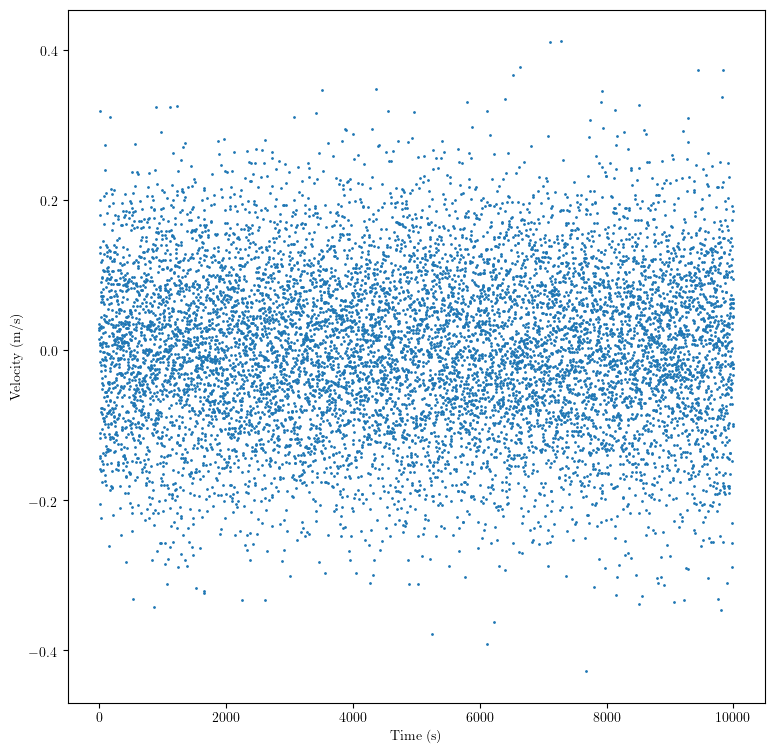

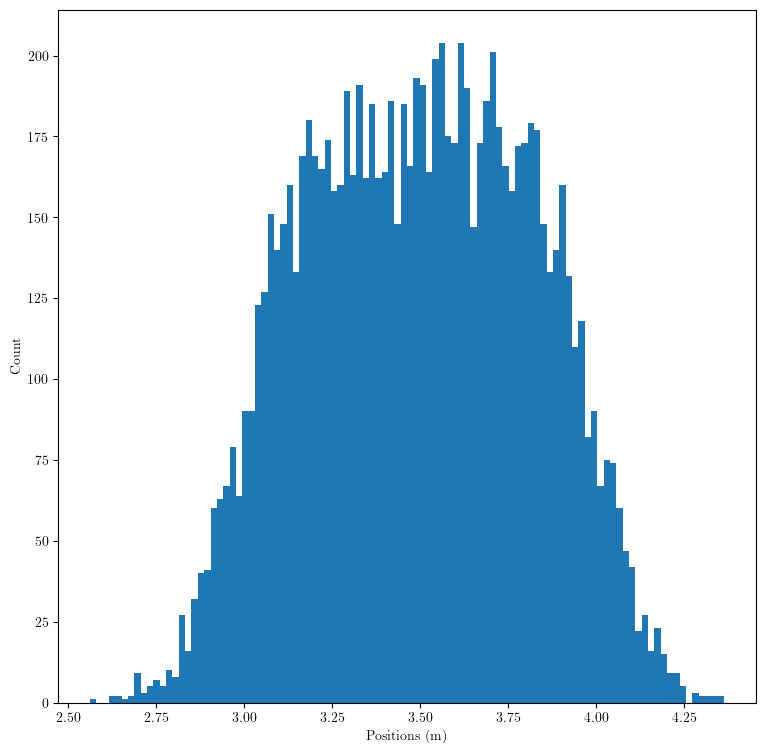

In [8]:
plt.scatter(t_data, x_data, s = 1)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()

plt.scatter(t_data, v_data, s = 1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()

plt.hist(x_data, bins = 100)
plt.xlabel("Positions (m)")
plt.ylabel("Count")
plt.show()

## Plot PSD

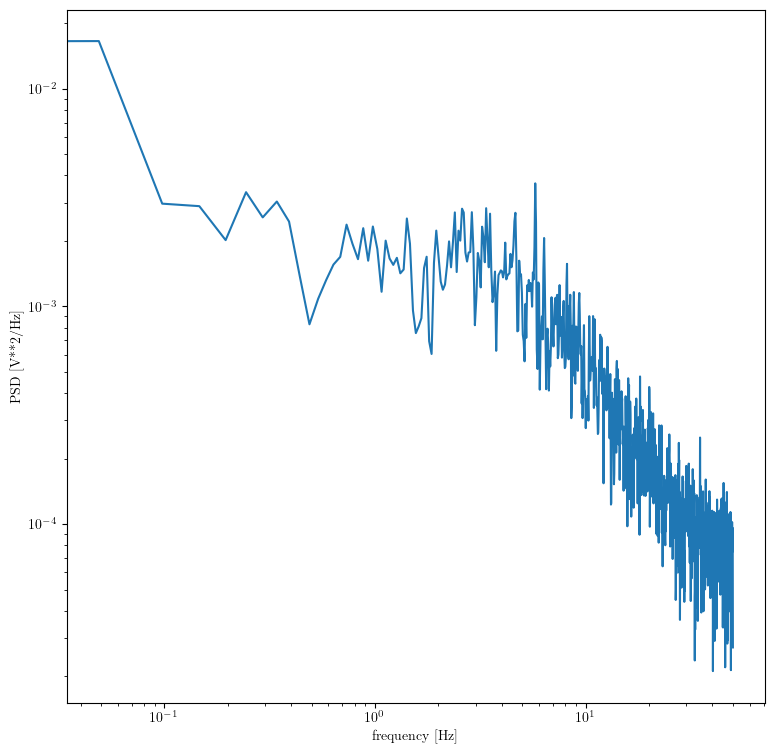

In [9]:
from scipy import signal
fs = 10e1
f, Pxx_den = signal.welch(x_data, fs, nperseg=2048)
plt.semilogy(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Plot Variability using Poincaré SD1 and SD2 over time

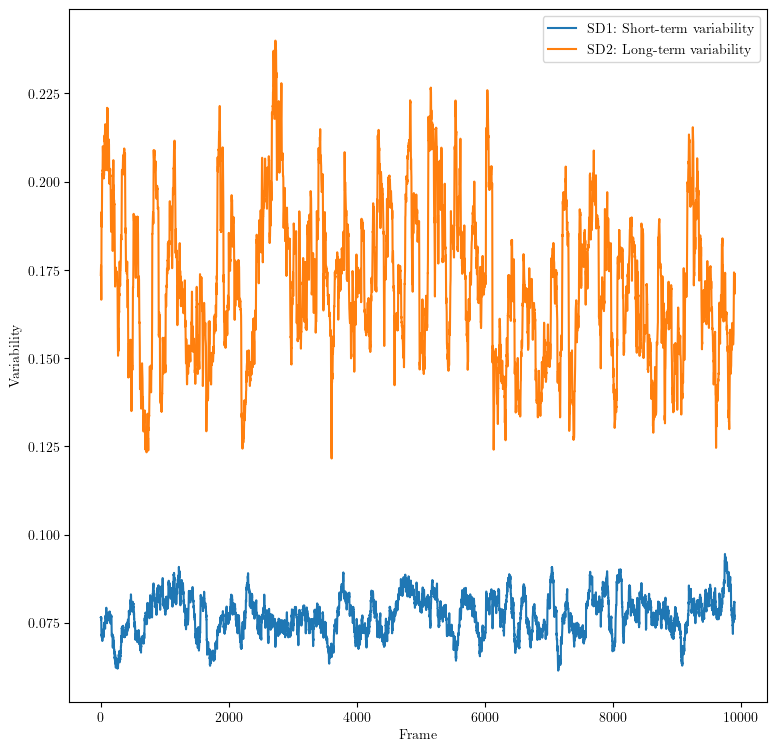

In [10]:
window = 100
sd1s = []
sd2s = []
for i in range(0, x_data.shape[0] - window, 1):
    RR_1 = x_data[i:i + window]
    RR_2 = x_data[i + 1:i + window + 1]

    x_1 = (RR_1 - RR_2) / 2**(0.5)
    x_2 = (RR_1 + RR_2) / 2**(0.5)

    sd1 = np.std(x_1)
    sd2 = np.std(x_2)

    sd1s.append(sd1)
    sd2s.append(sd2)

plt.plot(sd1s, label = "SD1: Short-term variability")
plt.plot(sd2s, label = "SD2: Long-term variability")
plt.ylabel("Variability")
plt.xlabel("Frame")
plt.legend()
plt.show()

## Plot Poincaré Density Plot

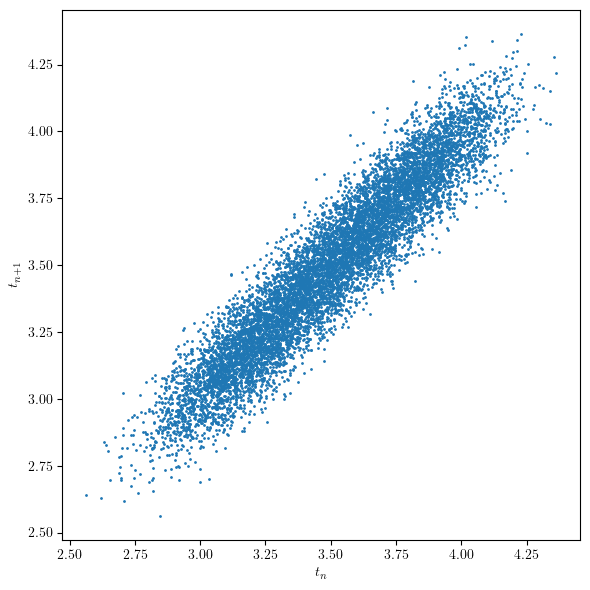

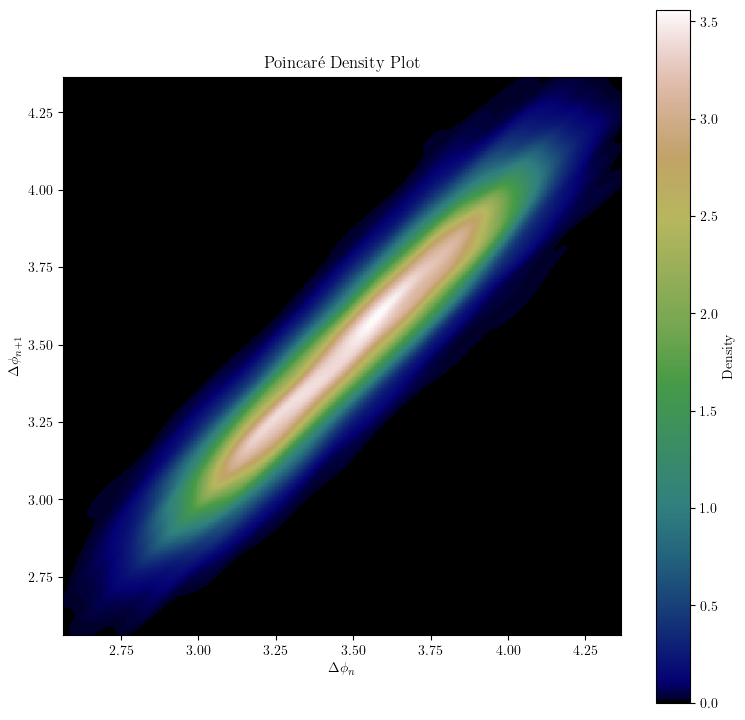

In [11]:
x = x_data[0:-1]
y = x_data[1::]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([x, y])

kernel = gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)

plt.figure(figsize = (6,6))
plt.scatter(x_data[0:-1], x_data[1::], s = 1)
plt.xlabel("$t_n$")
plt.ylabel("$t_{n+1}$")
plt.tight_layout()
plt.show()

plt.figure(figsize = (9,9))
plt.title("Poincaré Density Plot")
plt.imshow(Z, origin = "lower", cmap = "gist_earth", extent = [xmin, xmax, ymin, ymax], interpolation = "none")
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.colorbar(label = "Density")
plt.show()